In [91]:
import pandas as pd 
import numpy as np 
import configparser
import os
import seaborn as sns
import plotly_express as px

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import nltk 

from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne

config = configparser.ConfigParser()
config.read("env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
base_path = config['DEFAULT']['base_path']
code_dir = config['DEFAULT']['code_dir']

data_prefix = 'Maha'
out_path = f'{output_dir}/{data_prefix}'
OHCO = ['book_id','chap_id','sec_id','para_num', 'sent_num', 'token_num']


os.chdir(code_dir)
import preprocess
import bow_analysis
os.chdir(base_path)

SENTS = OHCO[:5]
PARA = OHCO[:4]
SECS = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [92]:
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 108, # THIS LIMITS OUR VOCAB
    workers = 8
)

In [93]:
CORPUS = pd.read_csv(fr"{output_dir}\F3\{data_prefix}-CORPUS.csv", sep="|").set_index(OHCO)

VOCAB = pd.read_csv(fr"{output_dir}\CHAP_BOW\{data_prefix}-VOCAB2.csv", sep="|").set_index('term_str')
VOCAB = VOCAB[~VOCAB.index.isna()]
VOCAB

,term_rank,index,n,n_chars,p,i,s,h,stop,stem_porter,...,n_pos,cat_pos,df,idf,dp,di,dh,dfidf,tfidf_mean,tfidf_sum
term_str,,,,,,,,,,,,,,,,,,,,,
the,1,26639,163915,3,6.803053e-02,3.877674,1.469928e+01,0.263800,1,the,...,2,"{'DT', 'VB'}",99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
of,2,18678,129501,2,5.374750e-02,4.217659,1.860552e+01,0.226689,1,of,...,1,{'IN'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
and,3,3003,95887,3,3.979650e-02,4.651215,2.512784e+01,0.185102,1,and,...,1,{'CC'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
that,4,26637,47382,4,1.966521e-02,5.668211,5.085123e+01,0.111467,1,that,...,6,"{'DT', 'VBP', 'IN', 'WDT', 'RB', 'NNP'}",99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
to,5,26929,43192,2,1.792621e-02,5.801786,5.578424e+01,0.104004,1,to,...,1,{'TO'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jamvunadi,30678,14683,1,9,4.150354e-07,21.200262,2.409433e+06,0.000009,0,jamvunadi,...,1,{'NNP'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,6.657043e-06,0.000659
jamvuvan,30679,14685,1,8,4.150354e-07,21.200262,2.409433e+06,0.000009,0,jamvuvan,...,1,{'NNP'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,3.396216e-06,0.000336
janani,30680,14693,1,6,4.150354e-07,21.200262,2.409433e+06,0.000009,0,janani,...,1,{'NN'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,2.544436e-07,0.000025


In [94]:
BAG = OHCO[:2]

docs = CORPUS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

docs = [doc for doc in docs if len(doc) > 1]
docs[:2]

[['anukramanika',
  'parva',
  'om',
  'having',
  'bowed',
  'down',
  'to',
  'narayana',
  'and',
  'nara',
  'the',
  'most',
  'exalted',
  'male',
  'being',
  'and',
  'also',
  'to',
  'the',
  'goddess',
  'saraswati',
  'must',
  'the',
  'word',
  'jaya',
  'be',
  'uttered',
  'ugrasrava',
  'the',
  'son',
  'of',
  'lomaharshana',
  'surnamed',
  'sauti',
  'wellversed',
  'in',
  'the',
  'puranas',
  'bending',
  'with',
  'humility',
  'one',
  'day',
  'approached',
  'the',
  'great',
  'sages',
  'of',
  'rigid',
  'vows',
  'sitting',
  'at',
  'their',
  'ease',
  'who',
  'had',
  'attended',
  'the',
  'twelve',
  'years',
  'sacrifice',
  'of',
  'saunaka',
  'surnamed',
  'kulapati',
  'in',
  'the',
  'forest',
  'of',
  'naimisha',
  'those',
  'ascetics',
  'wishing',
  'to',
  'hear',
  'his',
  'wonderful',
  'narrations',
  'presently',
  'began',
  'to',
  'address',
  'him',
  'who',
  'had',
  'thus',
  'arrived',
  'at',
  'that',
  'recluse',
  'abo

In [95]:
vocab = Dictionary(docs)

In [96]:
vocab

In [97]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [98]:
model.wv.vectors

array([[ 0.21974231, -0.01034579, -0.14716037, ..., -0.14033715,
        -0.11020087,  0.23079838],
       [ 0.01947925, -0.02320294, -0.6251523 , ..., -0.45581892,
        -0.6567276 , -0.8416629 ],
       [-0.32850182,  0.7778185 , -0.07163848, ..., -0.05144543,
        -0.1543761 ,  0.2629757 ],
       ...,
       [ 0.10269286,  0.07500654, -0.09126446, ..., -0.08197613,
        -0.07096484,  0.01040058],
       [ 0.09232962,  0.1308388 , -0.07841235, ..., -0.11496173,
        -0.18267483, -0.11027944],
       [-0.07774995,  0.07067478,  0.04262301, ..., -0.2230855 ,
        -0.20303145,  0.05481111]], dtype=float32)

In [110]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        # print(f"No - {w}")
        vec = None
    return vec

WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
WV

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
term_str,,,,,,,,,,,,,,,,,,,,,
the,0.219742,-0.010346,-0.147160,0.551525,-0.033315,-0.169469,0.435173,0.605161,-0.178964,0.143732,...,-0.751354,-0.103328,0.288905,-0.486095,-0.297680,0.136031,-0.032391,-0.140337,-0.110201,0.230798
of,0.019479,-0.023203,-0.625152,-0.306107,0.351162,0.065602,-0.817641,-0.474326,-0.262735,0.596323,...,-0.578464,0.294667,-0.337600,-0.139759,0.482827,0.409626,0.226339,-0.455819,-0.656728,-0.841663
and,-0.328502,0.777819,-0.071638,-0.572378,0.528402,0.282853,0.013135,0.164529,-0.517113,-0.236134,...,0.485731,0.469526,-0.224510,0.312956,0.508978,-0.460474,-0.103079,-0.051445,-0.154376,0.262976
that,0.512322,-0.032235,0.178502,0.035856,0.048577,-0.314039,0.347019,0.817350,-0.003324,0.211714,...,-0.493595,-0.634469,0.142485,-0.227274,0.073883,0.252656,-0.599143,0.317236,0.385066,-0.452525
to,-0.068330,0.003716,-0.257741,0.406727,0.955202,-0.025267,0.476906,-0.622643,-0.352491,0.980677,...,-1.134185,0.410053,0.887310,0.557065,0.169029,-0.218455,-0.386785,0.233220,1.282939,-0.286475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kali,0.102693,0.075007,-0.091264,0.136057,0.057741,-0.045336,0.051512,0.269075,-0.079037,0.116870,...,-0.013887,-0.030104,-0.047845,-0.025805,0.005093,0.120803,0.061012,-0.081976,-0.070965,0.010401
shame,-0.077750,0.070675,0.042623,0.259483,-0.020400,0.083021,0.145099,0.277138,-0.092391,0.032442,...,0.073925,0.118001,-0.027195,-0.025934,0.019618,0.151727,0.047180,-0.223085,-0.203031,0.054811
increase,0.024162,0.013962,0.028431,0.134392,0.071772,-0.006891,0.140665,0.242113,-0.081486,0.046693,...,0.144640,0.017326,-0.079766,0.001701,0.025310,0.111223,-0.033040,-0.148444,-0.150401,-0.032744


In [100]:
PP = 108
tsne_engine = tsne(
    perplexity=PP, 
    n_components=2, 
    init='pca', 
    n_iter=2500, 
    random_state=108)

In [101]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

C:\Users\vishg\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [102]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)
TSNE

,x,y
term_str,,
the,-5.809384,-7.842716
of,-7.201917,2.840472
and,-14.092367,-3.859819
that,-2.831620,-5.706170
to,10.803119,-2.252846
...,...,...
kali,-1.612132,-7.722503
shame,-0.512389,0.656100
increase,4.567632,3.447649


In [103]:
TSNE.reset_index()[TSNE.reset_index()['term_str'].apply(lambda x: x[:3]=='div')]

,term_str,x,y
213,diverse,-17.695366,-4.752521
745,divine,-1.032115,-8.084728
1100,division,-7.811032,-2.854658
1134,divested,-0.209552,10.288827
1295,divisions,-9.438460,-7.729188


In [118]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='RB']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [117]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='JJ']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [116]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='NN']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [115]:
X = TSNE.join(VOCAB, how='left')
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        size="dfidf",
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [105]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [120]:
get_most_similar('defeat',3)

,term,sim
0,kingdom,0.601740
1,fears,0.577615
2,foe,0.573457
3,journey,0.561637
4,word,0.522866
5,ancestors,0.511165
6,exile,0.510498
7,husbands,0.508928
8,welfare,0.508787
9,purpose,0.502269


In [135]:
complete_analogy('man', 'prince', 'woman', 5)

,term,sim
0,princess,0.814245
1,queen,0.750603
2,charioteer,0.703469
3,daughter,0.701467
4,vrikodara,0.696577


In [108]:
import sys
sys.path.append(code_dir)
from hac2 import HAC

<Figure size 640x480 with 0 Axes>

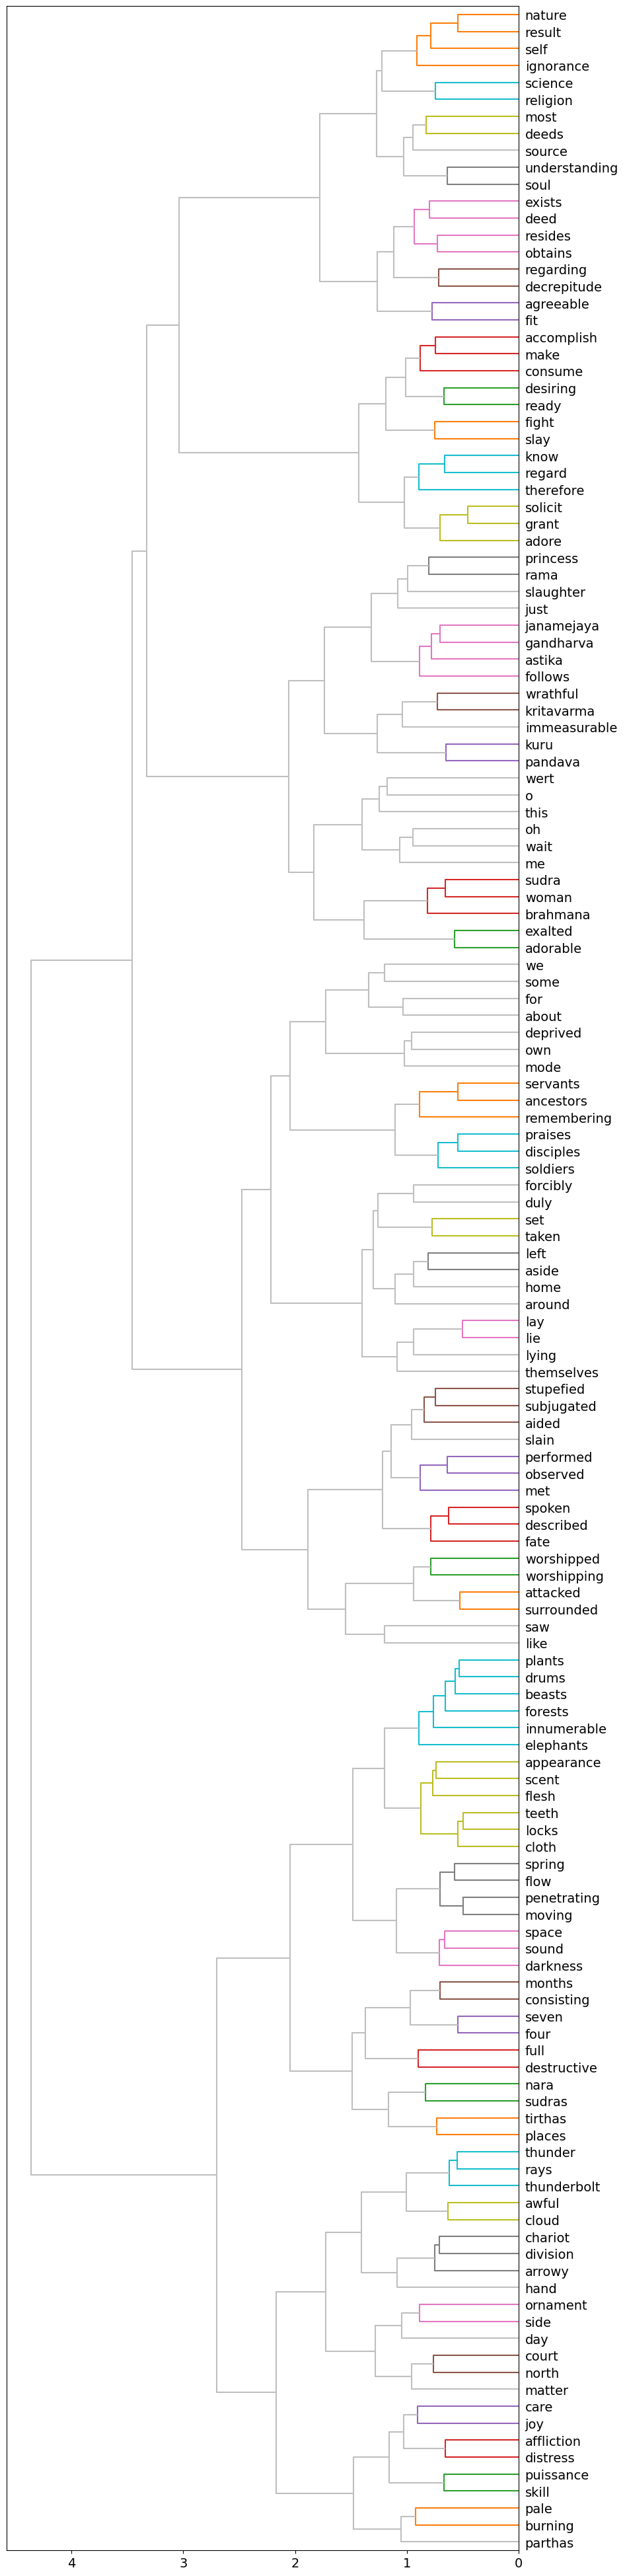

In [136]:
HAC(WV.sample(150)).plot()